### Preparations   

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

Брались только особи с полной информацией по родителям и ebv во избежание ошибок и обработки отдельных исключений.

Для корректного импорта файлов во время проверки кода нужно поместить папку data из архива задания в папку с кодом.

In [2]:
# loading and preparative processing of data
pedigree = pd.read_csv('data/pedigree.csv')

females = pd.read_csv('data/cows.csv')

bulls = pd.read_csv('data/bulls.csv')
males = bulls.drop('descendants_count', axis=1)

# merging pedigree and ebv data for each specimen with instant separation by missing ebv
females = pedigree.merge(females, on='id')
females = females[~females['ebv'].isna()].reset_index(drop=True)
males = pedigree.merge(males, on='id')
males = males[~males['ebv'].isna()].reset_index(drop=True)

# vizualization of ebv distribution in offspring
def distribution_plot(children):
  plt.figure(figsize=(16, 9))
  _, bins, _ = plt.hist(children.ebv, bins=1500, color='b')

  mean_ebv = np.mean(children.ebv)
  std_ebv = np.std(children.ebv)

  stats = {
      'mean': mean_ebv,
      'std': std_ebv,
      'metric': (mean_ebv * std_ebv)}

  stats_text = "\n".join([f"{k}: {v:.4f}" for k, v in stats.items()])

  # stats
  plt.text(0.02, 0.95, stats_text,
          transform=plt.gca().transAxes,
          bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'),
          fontfamily='monospace',
          verticalalignment='top')

  # trendline
  kde = gaussian_kde(children.ebv)
  x = np.linspace(children.ebv.min(), children.ebv.max(), 50)
  plt.plot(x, kde(x)*len(children.ebv)*(bins[1]-bins[0]),
          color='r', linewidth=2, label='density trend')

  # mean line
  plt.axvline(stats['mean'], color='lime', linestyle='--',
            linewidth=2, label=f'mean')

  plt.xlabel('ebv')
  plt.ylabel('number of specimens')
  plt.legend()
  plt.show()


# Introduction

Для сравнения изначально были реализованы элементарные алгоритмы: случайного подбора (**chaotic**) и подбора по соответствию из списков, ранжированных по ebv (**by merit**). Второй алгоритм предполагается лучшим, поскольку в нем при равном числе назначений коров на быка (задающемся вручную) точно будет достигнута большая дисперсия, чем в первом при том же одинаковом в среднем количестве назначений на быка (примерно равных из-за случайности). Также такой алгоритм будет соблюдать разноообразие и распредление ebv, заложенное на предыдущем этапе селекции, то есть в поколении родителей, которое скорее всего было продумано так же, как и на текущем этапе селекции.

В качестве основной метрики результата закреплений было использовано произведение стандартного отклонения ebv потомства на его ожидаемое среднее $E(ebv)*std(ebv)$, она в равной степени отражает значимость обоих характеристик и позволяет учесть их обе. Однако также можно использовать метрику в виде их взвешенной суммы с коэффициентом значимости одной из характеристик $\alpha E(ebv)+(1-\alpha)std(ebv)$, если требуется сделать акцент на одной из них в данной ситуации.

В подборе пар для скрещивания были учтены указанные биологические и селекционные ограничения: один бык покрывает не более 10% коров и при этом не является им близким родственником. Второй пункт был реализован из предположения, что в предложенной популяции ни одна особь не имеет значимого теоретического родства  $\leqslant\frac{1}{4}$, то есть особи могут являться друг другу родителями, детями или братьями (родство $	\geqslant\frac{1}{2}$), но не могут быть внуками или бабушками и далее, поскольку так алгоритм подбора был бы нерационально усложнен и выходил бы из формата одной строчки условий в операторе $\texttt{if}$, исходя из данных, предоставленных в таблицах.

# Prime algorithms

## Chaotic assortment

In [3]:
import random

# initialize dataframe for offspring records
children_chaotic = pd.DataFrame(columns=['father_id', 'mother_id', 'ebv'])
females_chaotic = females.copy()

# bulls in list of tuples
bulls_list = list(males.itertuples())

# mating counts per bull
coupling_numbers = {bull.id: 0 for bull in males.itertuples()}
coupling_limit = 0.1 * females.shape[0]

while not females_chaotic.empty:
    # random pick of bull and cow
    bull = random.choice(bulls_list)

    cow_idx = random.choice(females_chaotic.index)
    cow = females_chaotic.loc[cow_idx]

    # check relation bonds and coupling limit
    if (coupling_numbers[bull.id] < coupling_limit and
        cow.mother_id != bull.mother_id and
        cow.father_id != bull.father_id and
        cow.father_id != bull.id and
        bull.mother_id != cow.id):
            # calculate offspring's ebv
            child_ebv = np.mean([bull.ebv, cow.ebv])

            # create offspring specimen record
            children_chaotic.loc[len(children_chaotic)] = {
            'father_id': bull.id,
            'mother_id': cow.id,
            'ebv': child_ebv}

            # remove mated cow from pool
            females_chaotic = females_chaotic.drop(cow_idx)

            coupling_numbers[bull.id] += 1

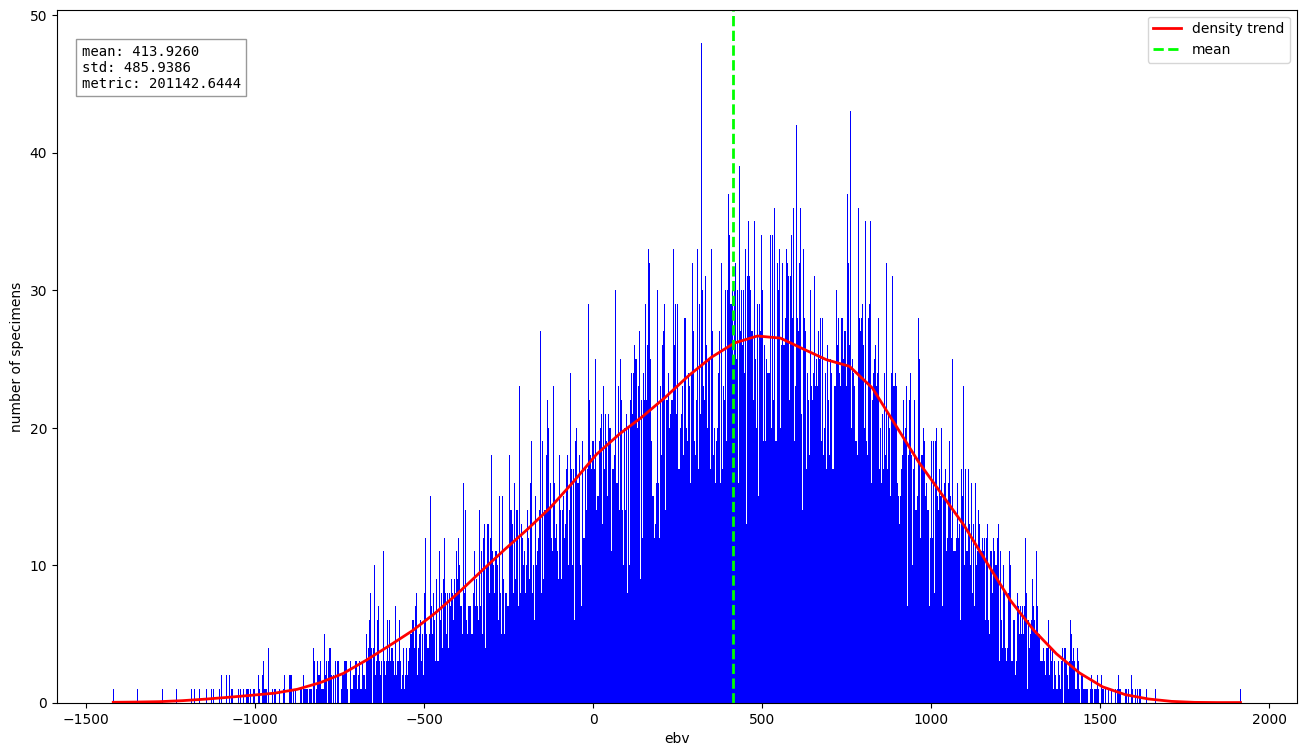

In [4]:
distribution_plot(children_chaotic)

Как видно, распределение, полученное таким образом, близко к нормальному и имеет низкую дисперсию в сравнении с популяцией родителей.

## Assortment by merit

In [11]:
from math import ceil

# sorting dataframes for this algorithm
females_sorted = females.sort_values('ebv',ascending=False).reset_index(drop=True)
males_sorted = males.sort_values('ebv',ascending=False).reset_index(drop=True)

In [12]:
coupling_per_bull = ceil(females.shape[0] / males.shape[0])

children_merit = pd.DataFrame(columns=['father_id', 'mother_id', 'ebv'])
females = females_sorted.copy()

for bull in males_sorted.itertuples():
    cows_assigned = 0
    cow_idx = 0  # start from the beginning for each bull

    while cows_assigned < coupling_per_bull and cow_idx < len(females):
        cow = females.iloc[cow_idx]

        # check relation bonds
        if (cow.mother_id != bull.mother_id and
            cow.father_id != bull.father_id and
            cow.father_id != bull.id and
            bull.mother_id != cow.id):

            # calculate offspring's ebv
            child_ebv = np.mean([bull.ebv, cow.ebv])

            # create offspring specimen record
            children_merit.loc[len(children_merit)] = {
            'father_id': bull.id,
            'mother_id': cow.id,
            'ebv': child_ebv}

            # remove mated cow
            females = females.drop(females.index[cow_idx]).reset_index(drop=True)
            cows_assigned += 1
        else:
            # move to next cow if current cow is ineligible
            cow_idx += 1

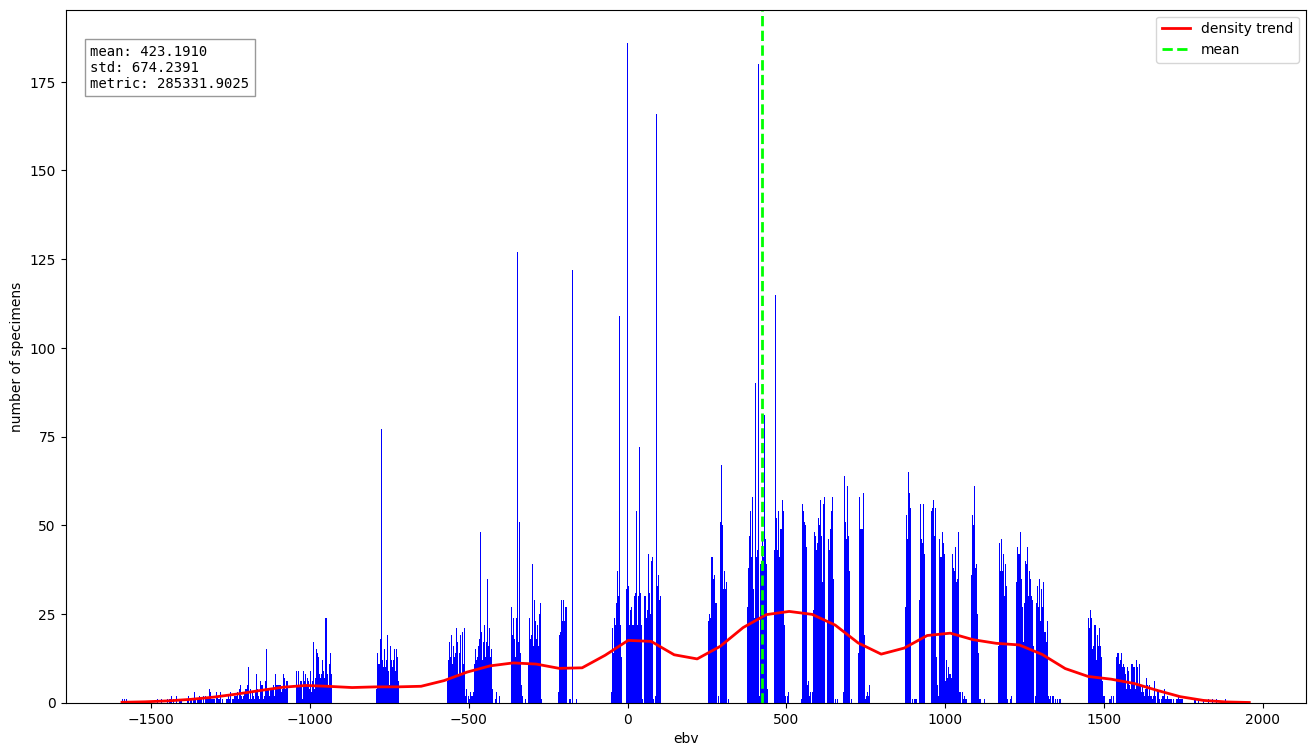

In [13]:
distribution_plot(children_merit)

В предпочтительном же алгоритме подбора с ранжированными списками ожидаемое среднее отличается незначительно, однако дисперсия намного выше, что и дает вклад в метрику качества.

# Optimization algorithms

Как было показано выше, стоит развивать идею алгоритма с ранжированными списками, на эту роль подходит алгоритм градиентного спуска (в данном случае, подъема), где в качестве параметров оптимизации используются веса быков, то есть доля коров, которых им предстоит оплодотворить. Причем как список самцов, так и список самок ранжирован и каждому быку будет соответствовать последовательно отрезок из списка коров, отмеренный предписанным ему весом-долей.

## Assortion with gradient ascent

Алгоритм состоит из трех основных функций: 
  -  $\texttt{mating()}$ $-$ расчет таблиц получившихся потомков из ранжированных списков родителей, содержащих оба их id и рассчитанный усредненный ebv.
  -  $\texttt{gradient()}$ $-$ собственно расчет градиента. На определенном этапе написания был оптимизирован путем сохранения ebv детей от быков, находящихся выше по списку относительно быка, по которому рассчитывается частичная производная в данный момент и последующего их объединения, таким образом была достигнута сложность алгоритма $O(n\log(n))$, вместо изначального $O(n^2)$, когда все рассчитывалось полностью на каждом этапе.
  -  и функция обновления весов $-$ $\texttt{update\_weights()}$. Она интересна тем, что веса, сумма которых, очевидно, должна быть равна $1$ нормализуются не путем деления на их сумму, поскольку они могут содержать пороговые веса $=0.1$, которые не могут стать больше. Нормализация происходит, не затрагивая эти веса, путем нахождения остатка, недостающего до равенства всей суммы весов единице, и умножения этого остатка на "обратные веса". "Обратные веса"  соответствуют каждому изначальному весу, они предсталяют число, недостающее весу, чтобы достигнуть порога и нормализуются стандартно. Таким образом, сумма вектора весов достигает $1$ без классической нормализации и распределение весов становится более сглаженным.
    
Также он включает в себя цикл обучения, который содержит все эти функции и на каждом этапе визуализируется новым распределением.

In [28]:
def mating(weights, males, females):
    '''
    producing of children dataframe with target ebvs
    '''
    children = pd.DataFrame(columns=['father_id', 'mother_id', 'ebv'])

    females_opt = females.copy()
    females_num = females_opt.shape[0]

    for i in range(len(males)):
        bull = males.iloc[i]
        cows_assigned = 0
        cow_idx = 0  # start from the beginning for each bull

        # number of cows per bull depends on his weight
        coupling_per_bull = int(females_num * weights[i])

        while (cows_assigned < coupling_per_bull and cow_idx < len(females_opt)):
            cow = females_opt.iloc[cow_idx]

            # check relation bonds
            if (cow.mother_id != bull.mother_id and
                cow.father_id != bull.father_id and
                cow.father_id != bull.id and
                bull.mother_id != cow.id):

                # calculate offspring's ebv
                child_ebv = np.mean([bull.ebv, cow.ebv])

                # create offspring specimen record
                children.loc[len(children)] = {
                'father_id': bull.id,
                'mother_id': cow.id,
                'ebv': child_ebv}

                # remove mated cow
                females_opt = females_opt.drop(females_opt.index[cow_idx]).reset_index(drop=True)
                cows_assigned += 1
            else:
                # move to next cow if current cow is ineligible
                cow_idx += 1

    return children

def gradient(weights, males, females, epsilon=1e-3, limit=0.1):
    '''
    computing approximate gradient of metric function
    '''
    grad = np.zeros_like(weights)

    bulls_preset = np.array([])
    cows_num = females.shape[0]
    cow_idx = 0

    # computing current value of score-function
    children_base = mating(weights, males, females)
    base_ebvs = children_base.ebv.values

    base_mean = np.mean(base_ebvs)
    base_std = np.std(base_ebvs)
    base_score = base_mean * base_std

    for i in range(len(weights)):
        new_weights = np.array(weights.copy())

        print(i, 'partial derivative', end='\r')
        # considering the limit of cows per bull add
        if new_weights[i] + epsilon >= limit:
          new_weights[i] = limit
        else:
          new_weights[i] += epsilon

        # normalization of weights under the limit
        underlimit_weights_mask = (new_weights < limit)
        underlimit_weights = np.where(underlimit_weights_mask, new_weights, 0)

        # renewal of weights with normalized and utmost weights
        new_weights = [underlimit_weights[i] if underlimit_weights_mask[i] else new_weights[i]
                      for i in range(len(weights))]

        # bring sum of weights to one with limit-reaching values for each weight
        weights_residue = 1 - np.sum(new_weights)
        invertweights = np.array([limit - i for i in new_weights])
        invertweights /= np.sum(invertweights)

        new_weights = new_weights + weights_residue * invertweights

        # optimization of taking gradient
        if i > 0:
          cow_idx = int(np.sum(weights[:i-1] * cows_num))

        children_new = mating(new_weights[i:], males.iloc[i:], females.iloc[cow_idx:])
        new_ebvs = children_new.ebv.values

        # save mean values that have been computed already (above current partial derivative)
        bulls_preset = np.concatenate([bulls_preset, new_ebvs[:cow_idx]])

        # concatenate new vector from preset and computations
        new_ebvs = np.append(bulls_preset, new_ebvs)

        # calculate final metric with difference
        new_mean = np.mean(new_ebvs)
        new_std = np.std(new_ebvs)
        new_score = new_mean * new_std

        # update gradient vector
        grad[i] = (new_score - base_score) / epsilon

    # normalize gradient vector
    grad /= np.sum(np.absolute(grad))

    return grad

def update_weights(weights, gradient, learning_rate=1e-3, limit=0.1):
    step = weights + learning_rate * gradient

    # considering the limit of cows per bull
    new_weights = np.array(np.clip(step, 0, limit))

    # normalization of weights under the limit
    underlimit_weights_mask = (new_weights < limit)
    underlimit_weights = np.where(underlimit_weights_mask, new_weights, 0)

    # renewal of weights with normalized and utmost weights
    new_weights = [underlimit_weights[i] if underlimit_weights_mask[i] else new_weights[i]
                   for i in range(len(weights))]

    # bring sum of weights to one with limit-reaching values for each weight
    weights_residue = 1 - np.sum(new_weights)
    invertweights = np.array([limit - i for i in new_weights])
    invertweights /= np.sum(invertweights)

    new_weights = new_weights + weights_residue * invertweights

    print(new_weights, np.sum(new_weights))
    return new_weights

В качестве начальных координат вектора весов для оптимизации были выбраны два предельных случая: равномерное распределение коров по быкам и распределение с максимальной дисперсией, то есть пороговые веса у быков с наибольшим и с наименьшим ebv.

[0.03867303 0.03521829 0.03407259 0.03845    0.0447255  0.05016542
 0.05356903 0.05388321 0.05136713 0.04693048 0.04145894 0.03580775
 0.03063628 0.02648038 0.02353553 0.02191729 0.02003086 0.01792719
 0.01675755 0.01675755 0.01675755 0.01675755 0.01675755 0.01675755
 0.01675755 0.01675755 0.01675755 0.01675755 0.01675755 0.01675755
 0.01675755 0.01675755 0.01675755 0.01675755 0.01675755 0.01675755
 0.01675755 0.01675755] 0.9999999999999998


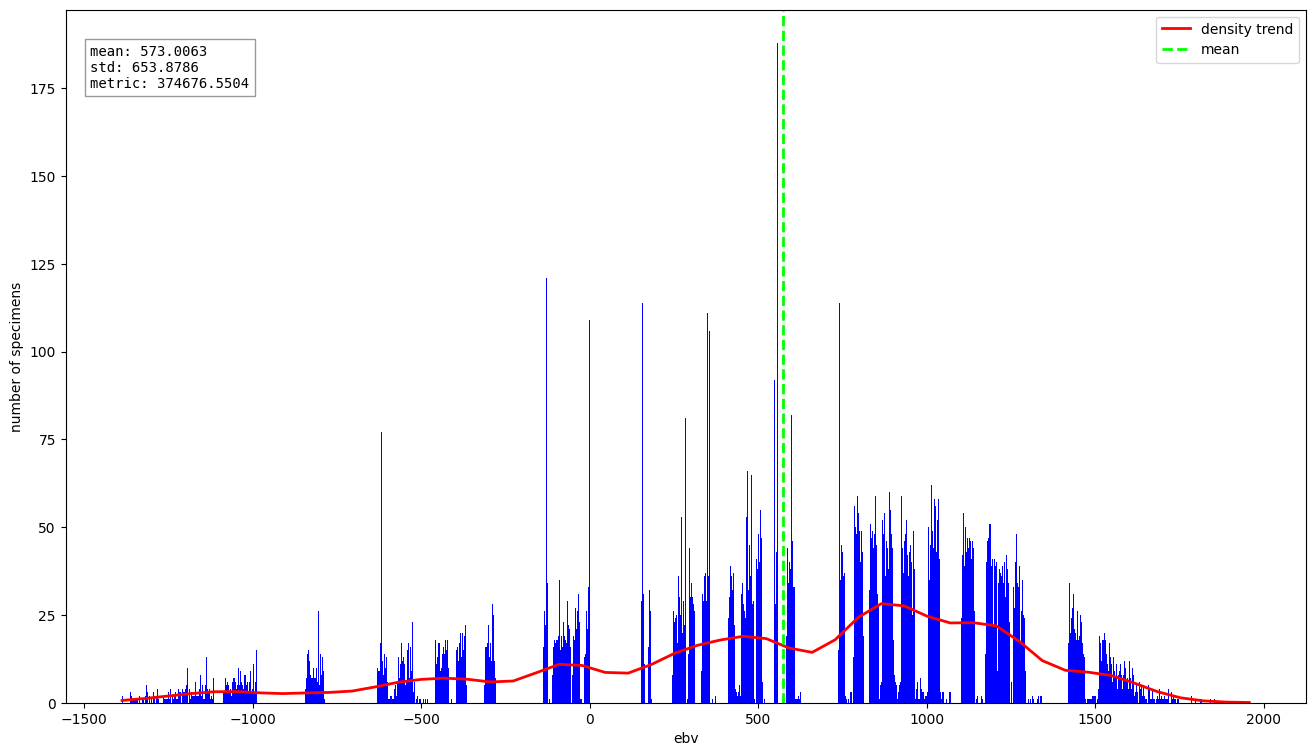

[0.04887601 0.04277946 0.04011406 0.04610531 0.0539167  0.05890905
 0.05963439 0.05547938 0.04804174 0.04141633 0.03560304 0.02911173
 0.0230192  0.01798997 0.01662515 0.01662515 0.01662515 0.01662515
 0.01662515 0.01662515 0.01662515 0.01662515 0.01662515 0.01662515
 0.01662515 0.01662515 0.01662515 0.01662515 0.01662515 0.01662515
 0.01662515 0.01662515 0.01662515 0.01662515 0.01662515 0.01662515
 0.01662515 0.01662515] 1.0


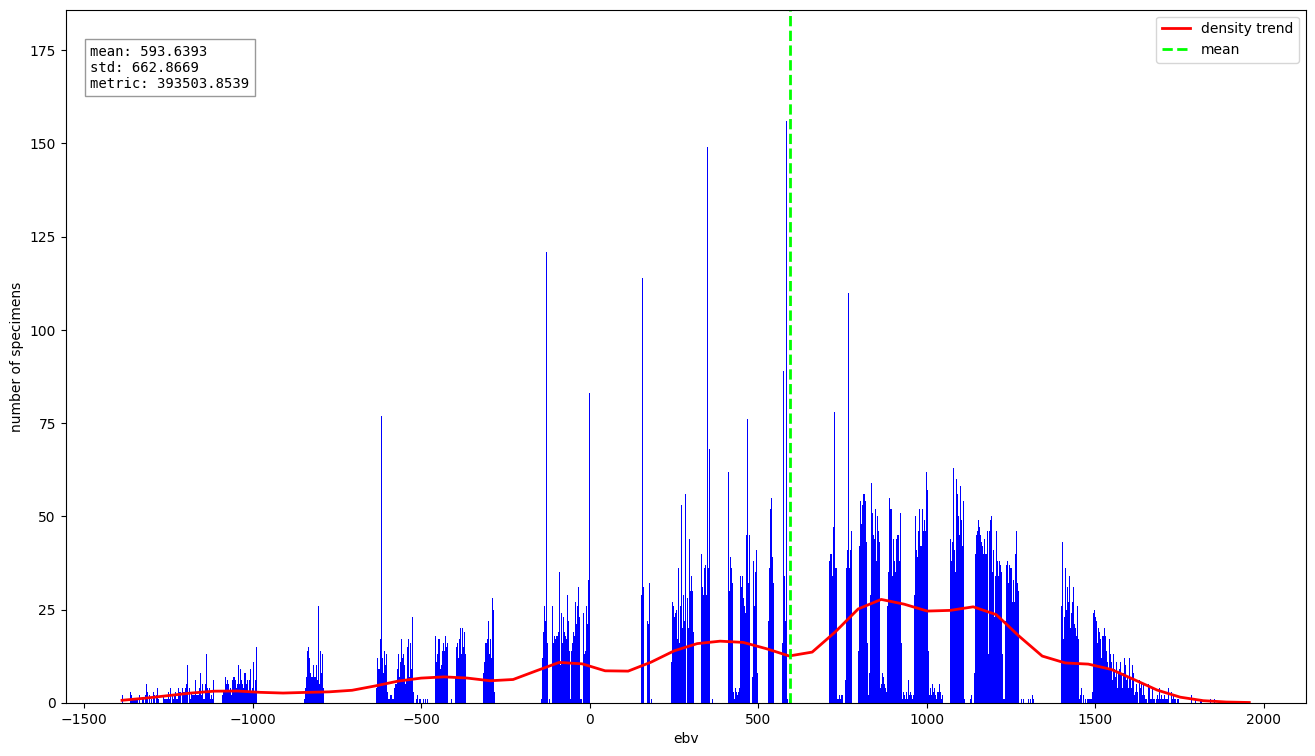

[0.05730428 0.04892633 0.04484107 0.05200625 0.06031084 0.06362551
 0.06065122 0.05213196 0.04320169 0.03631647 0.02973284 0.02262936
 0.01647393 0.01647393 0.01647393 0.01647393 0.01647393 0.01647393
 0.01647393 0.01647393 0.01647393 0.01647393 0.01647393 0.01647393
 0.01647393 0.01647393 0.01647393 0.01647393 0.01647393 0.01647393
 0.01647393 0.01647393 0.01647393 0.01647393 0.01647393 0.01647393
 0.01647393 0.01647393] 0.9999999999999997


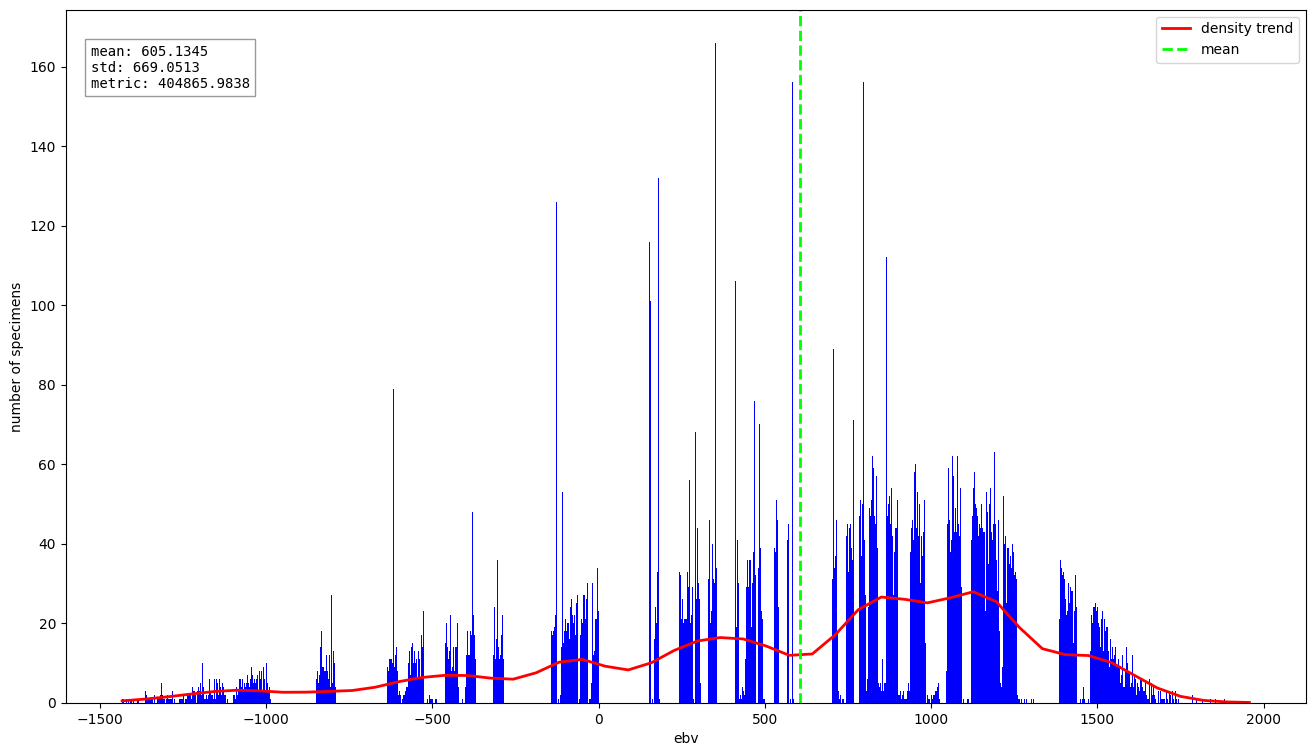

In [29]:
males_opt = males_sorted.copy()
females_opt = females_sorted.copy()

n_bulls = males_opt.shape[0]
weights = np.ones(n_bulls) / n_bulls  # start with equal weights
# weights = np.zeros(n_bulls, dtype=np.float32); weights[:5] = 0.1; weights[-5:] = 0.1 # start with max мariance

epsilon = 1 / len(females_opt)
lr = 1
limit = 0.1

for epoch in range(3):
    grad = gradient(weights, males_opt, females_opt, epsilon, limit)
    weights = update_weights(weights, grad, lr, limit)

    children = mating(weights, males_opt, females_opt)

    distribution_plot(children)

[0.1        0.09675804 0.09613001 0.09869709 0.09201817 0.00584824
 0.00584824 0.00584824 0.00584824 0.00584824 0.00584824 0.00584824
 0.00584824 0.00584824 0.00584824 0.00584824 0.00584824 0.00584824
 0.00584824 0.00584824 0.00584824 0.00584824 0.00584824 0.00584824
 0.00584824 0.00584824 0.00584824 0.00584824 0.00584824 0.00584824
 0.00584824 0.00584824 0.00584824 0.07061273 0.07060597 0.07051774
 0.07045604 0.07045339] 0.9999999701976776


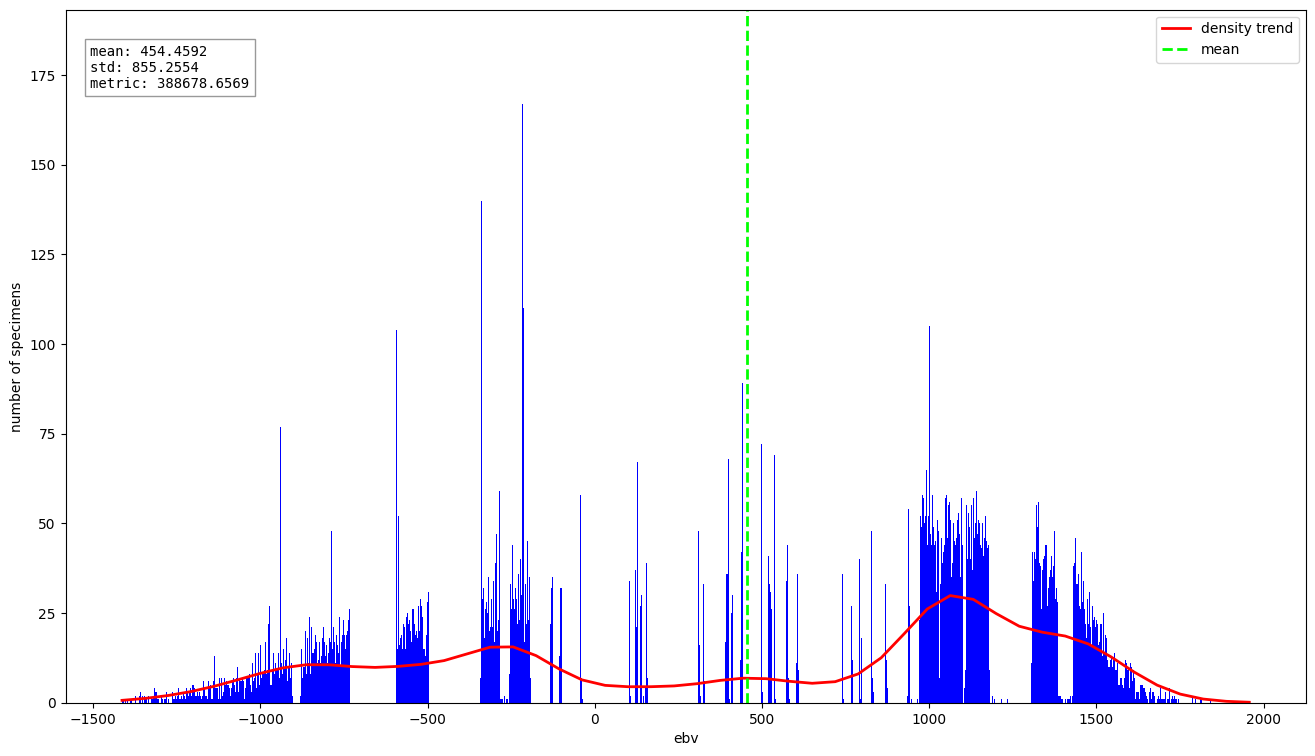

[0.1        0.09437134 0.09276857 0.09771374 0.08749833 0.01114714
 0.01114714 0.01114714 0.01114714 0.01114714 0.01114714 0.01114714
 0.01114714 0.01114714 0.01114714 0.01114714 0.01114714 0.01114714
 0.01114714 0.01114714 0.01114714 0.01114714 0.01114714 0.01114714
 0.01114714 0.01114714 0.01114714 0.01114714 0.01114714 0.01114714
 0.01114714 0.01114714 0.01114714 0.04334331 0.04322477 0.04304531
 0.04295292 0.04296183] 1.0000000000000002


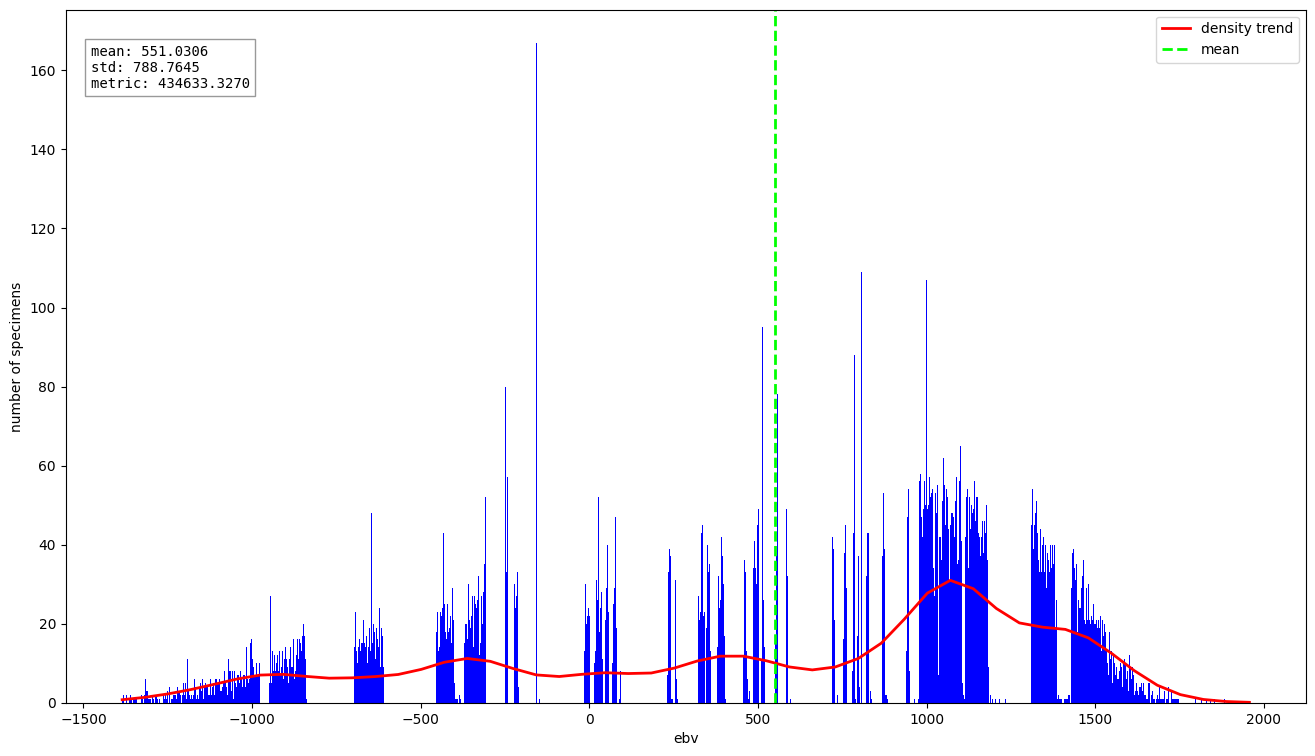

[0.1        0.092529   0.08953435 0.09518088 0.08299652 0.01538567
 0.01538567 0.01538567 0.01538567 0.01538567 0.01538567 0.01538567
 0.01538567 0.01538567 0.01538567 0.01538567 0.01538567 0.01538567
 0.01538567 0.01538567 0.01538567 0.01538567 0.01538567 0.01538567
 0.01538567 0.01538567 0.01538567 0.01538567 0.01538567 0.01538567
 0.01538567 0.01538567 0.01538567 0.02213093 0.02191276 0.021694
 0.02159974 0.02162301] 1.0


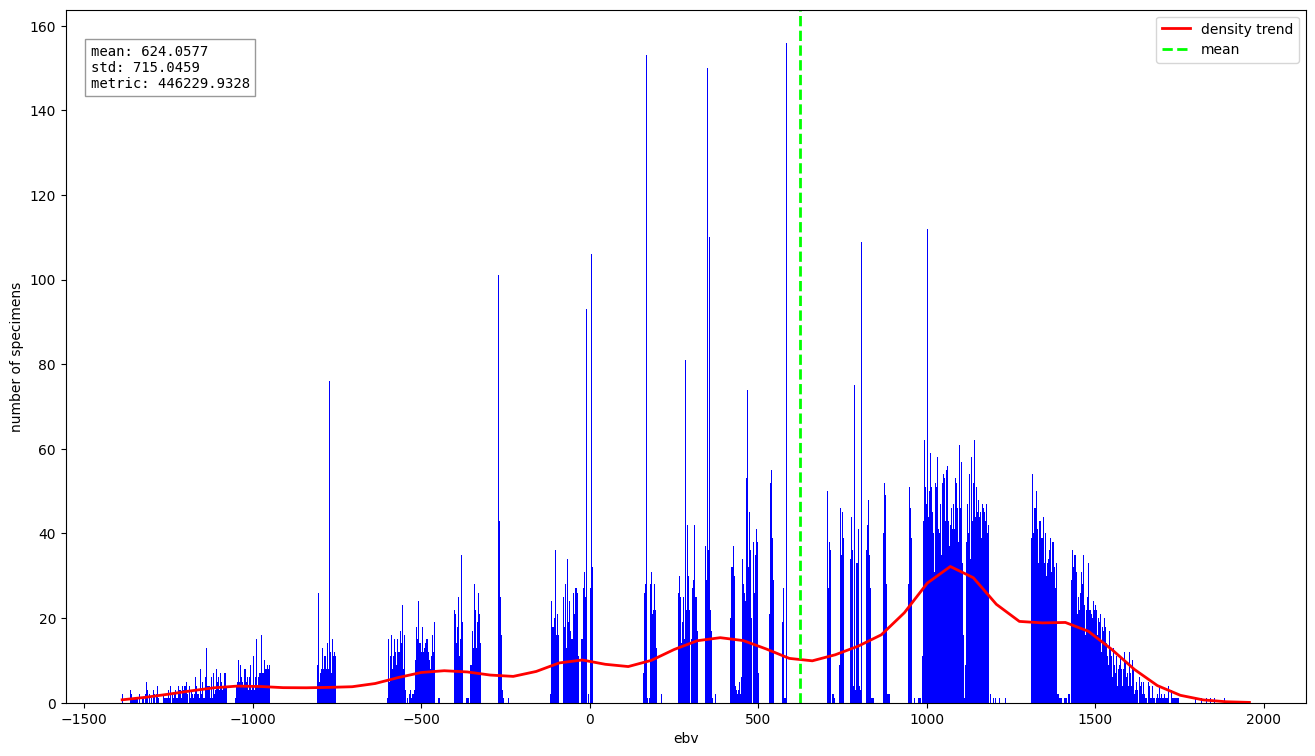

In [30]:
males_opt = males_sorted.copy()
females_opt = females_sorted.copy()

n_bulls = males_opt.shape[0]
# weights = np.ones(n_bulls) / n_bulls  # start with equal weights
weights = np.zeros(n_bulls, dtype=np.float32); weights[:5] = 0.1; weights[-5:] = 0.1 # start with max variance

epsilon = 1 / len(females_opt)
lr = 1
limit = 0.1

for epoch in range(3):
    grad = gradient(weights, males_opt, females_opt, epsilon, limit)
    weights = update_weights(weights, grad, lr, limit)

    children = mating(weights, males_opt, females_opt)

    distribution_plot(children)

Как можно понять, лучшая метрика быстрее достигается во втором случае с весам для наибольшей дисперсии, при том в итоге дисперсия в обоих случаях значительно не различается, а вот ожидаемое среднее ebv выходит намного выше, внося свой вклад в метрику и общую селекционную ценность всей полученной популяции детей. Распределение приобретает дискретный вид со сосредоточением плотности по пулам телят, полученных от каждого быка.

Однако проверим также продвинутый алгоритм, основанный на случайном подборе, для такого подходит генетический эволюционный алгоритм.

## Assortion with genetic algorithm

Основные положения алгоритма:

  - Единицей отбора (особью или хромосомой) принимается таблица параметров детей, полкченных в рещультате скрещивания случайно подобранных друг другу быков и коров
  - Популяция $-$ множество подобных "особей", среди которых происходит отбор наиболее приспособленных (имеющих наибольшую метрику качества)
  - Алгоритм включается в себя следующие шаги:

      1. Создание изначальной родительской популяции
      2. Попарное случайное скрещивание (кроссинговер) особей-хромосом
      3. Отбор особей с максимальными метриками в новой популяции родители$-$дети (каждый раз полученная популяция равна численности детей, то есть в два раза меньше родительской)
      4. Проведение мутационных изменения отобранных особей (опционально)
    

Он также состоит из трех основных функций: 
  -  $\texttt{mating()}$ $-$ аналогичный расчет таблиц со случайным подбором.
  -  $\texttt{crossover()}$ $-$ функция скрещивания (кроссинговера) особей-хромосом, принимающая количество разрывов, по которым происходит обмен участками, учитывающая поставленные ограничесния и обновляющая словарь покрытий на быка.
  -  $\texttt{mutate()}$ $-$ производит мутацию (случайную замену быка у коровы и обновление ebv ребенка) случайных "пар оснований", размер части которых опрделяет параметр $\texttt{mutation\_rate}$. Она также учитывает все ограничения и обновляет словарь покарытий.
    
Результатом выполнения алгоритма является популяция, состоящая из единстенной отобранной таблицы потомков с наивысшей метрикой.

In [25]:
def mating(males, females, limit):
    '''
    producing of children dataframe with target ebvs
    '''
    females_chaotic = females.copy()
    children_chaotic = pd.DataFrame(columns=['father_id', 'mother_id', 'ebv'])
    females_num = females.shape[0]

    # bulls in list of tuples
    bulls_list = list(males.itertuples())

    # mating counts per bull
    coupling_numbers = {bull.id: 0 for bull in males.itertuples()}
    coupling_limit = limit * females_num

    cow_idx = 0

    while cow_idx < females_num:
      # random pick of bull for a cow
      cow = females_chaotic.loc[cow_idx]

      bull = random.choice(bulls_list)

      # check relation bonds
      if (coupling_numbers[bull.id] < coupling_limit and
          cow.mother_id != bull.mother_id and
          cow.father_id != bull.father_id and
          cow.father_id != bull.id and
          bull.mother_id != cow.id):
            # calculate offspring's ebv
            child_ebv = np.mean([bull.ebv, cow.ebv])

            # create offspring specimen record
            children_chaotic.loc[len(children_chaotic)] = {
            'father_id': bull.id,
            'mother_id': cow.id,
            'ebv': child_ebv}

            # update coupling counter for each bull
            coupling_numbers[bull.id] += 1

            # move to the next cow
            cow_idx += 1

    return children_chaotic, coupling_numbers

def crossover(parent1, parent2, males, cross_num):
    '''
    producing of children dataframe with optimal ebv by crossover between parents
    considering parental dataframes as chromosomes
    '''
    length = parent1.shape[0]

    # gather places of rupture (indeces of cows)
    rupture_place = sorted([random.randint(0, length - 1) for _ in range(cross_num)])

    # applying ruptures in particular places of 'chromosome'
    for cow in rupture_place:
      child1 = pd.concat([parent1.iloc[:cow], parent2.iloc[cow:]])
      child2 = pd.concat([parent2.iloc[:cow], parent1.iloc[cow:]])

    # choosing child with max score
    score1 = np.mean(child1.ebv.values) * np.std(child1.ebv.values)
    score2 = np.mean(child2.ebv.values) * np.std(child2.ebv.values)

    children = {score1: child1, score2: child2}
    preferred_child = children[max(children.keys())]

    # update coupling score
    coupling_numbers = {bull.id: 0 for bull in males.itertuples()}
    for father in preferred_child.father_id.values:
      coupling_numbers[father] += 1

    return preferred_child, coupling_numbers

def mutate(children, coupling_numbers, males, females, mutation_rate, limit):
    '''
    producing of children dataframe with mutated [mutation_rate] part of cows
    each cow gets new bull considering all limitations
    '''
    mutated_children = children.copy()
    coupling_limit = limit * females.shape[0]

    # preparations
    length = children.shape[0]
    mutations_num = int(mutation_rate * length)
    mutations = sorted([random.randint(0, length - 1) for _ in range(mutations_num)])

    # iterating through 'chromosome'
    for mutation in mutations:
      child = children.iloc[mutation]
      mother = females[females['id'] == child.mother_id].iloc[0]

      # choosing appropriate bull
      relation_condition = False
      while not relation_condition:
        bull = random.choice(list(males.itertuples()))

        relation_condition = (coupling_numbers[bull.id] < coupling_limit and
            mother.loc['mother_id'] != bull.mother_id and
            mother.loc['father_id'] != bull.father_id and
            mother.loc['father_id'] != bull.id and
            bull.mother_id != mother.loc['id'])

        # calculate offspring's ebv
        child_ebv = np.mean([bull.ebv, mother.loc['ebv']])

        # update of coupling numbers vector
        coupling_numbers[child.father_id] -= 1
        coupling_numbers[bull.id] += 1

        # perform 'snp'
        mutated_children.iloc[mutation] = {
        'father_id': bull.id,
        'mother_id': mother.loc['id'],
        'ebv': child_ebv}

    return mutated_children, coupling_numbers

Создание изначальной популяции

In [6]:
females_chaotic = females.copy()

population_num = 64
population = {}

# create parental chromosomes population
for _ in range(population_num):
  children = mating(males, females_chaotic, 0.1)
  ebvs = children[0].ebv.values
  score = np.mean(ebvs) * np.std(ebvs)

  population[score] = children

Цикл отбора

In [8]:
cross_num = 2
limit = 0.1
mutation_rate = 0.1

# optimization function
def selection(population_, cross_num, limit, mutation_rate):
    population = population_.copy()

    while len(population) > 1:
      specimens = list(population.keys())
      new_population_num = int(len(population) / 2)

      print('mean population score', np.mean(specimens))
      while len(specimens) > 0:
        # initialization of parents
        key_idx1 = random.randint(0, len(specimens) - 1)
        key1 = specimens.pop(key_idx1)
        specimen1 = population[key1]

        key_idx2 = random.randint(0, len(specimens) - 1)
        key2 = specimens.pop(key_idx2)
        specimen2 = population[key2]

        # coupling of two children dataframes
        child = crossover(specimen1[0], specimen2[0], males, cross_num)
        ebvs = child[0].ebv.values
        score = np.mean(ebvs) * np.std(ebvs)

        population[score] = child

      # selection of the most high-scored scpecimens
      selection_keys = sorted(list(population.keys()), reverse=True)[:new_population_num]
      population = {key: population[key] for key in selection_keys}

      # performing mutation on children dataframes
      for key in selection_keys:
        population[key] = mutate(population[key][0], population[key][1], males, females_chaotic, mutation_rate, limit)

    return population

new_population = selection(population, cross_num, limit, mutation_rate)

mean population score 204312.88671965647
mean population score 206418.45844633048
mean population score 208054.96572007332
mean population score 209277.08757208788
mean population score 210243.23108892606
mean population score 210708.61539075192


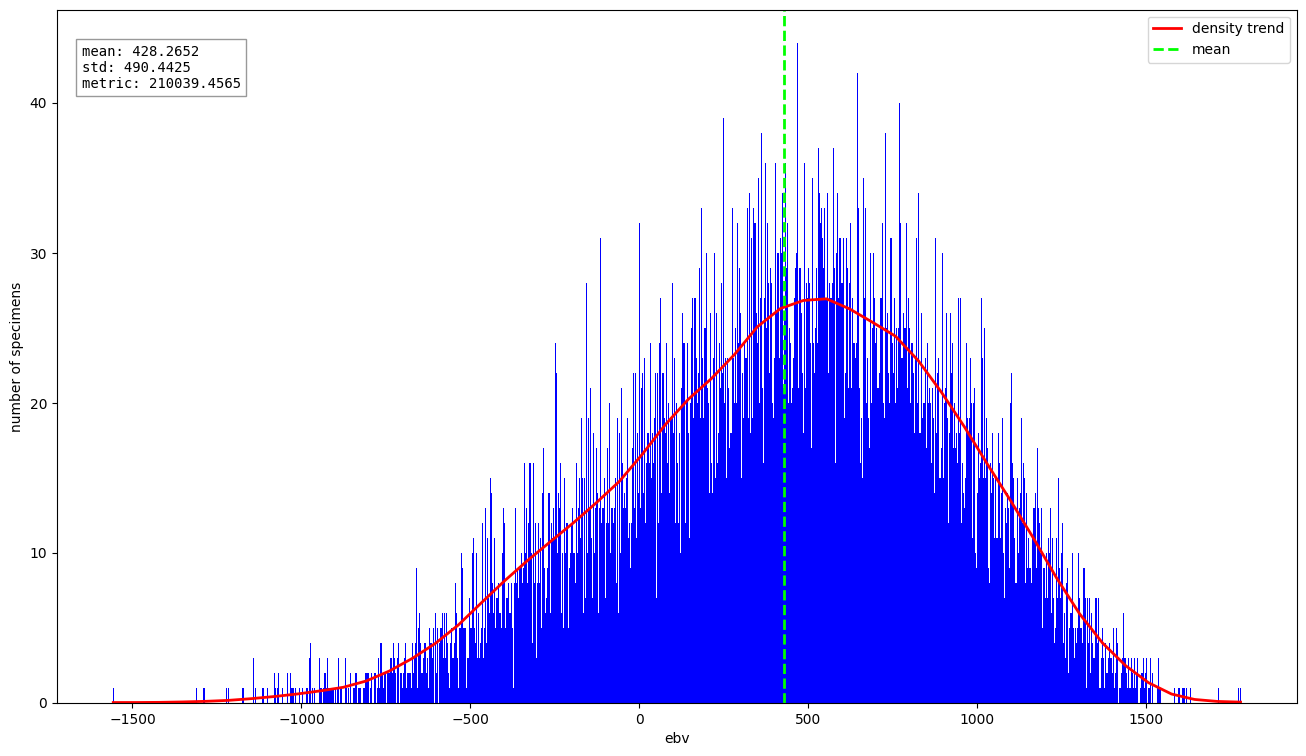

In [10]:
key = list(new_population.keys())[0]
children_evolution = new_population[key][0]

distribution_plot(children_evolution)

Однако, следуя изначальному предположении об эффективности алгоритмов, при сравнимом количестве итераций расчета таблиц с детьми (исходной популяции) и шести итераций отбора алгоритм дает небольшой прирост метрики в сравнении со средним значением по изначальной родительской популяции. И итоговое распределение также несильно отличается от случайно-нормального.